Import model and custom functions

In [1]:
from keras.models import load_model
from keras.utils import Sequence
import numpy as np
import tensorflow as tf

C:\Users\Panu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mae_exclude_padding(y_true, y_pred):
    """

    Args:
        y_true, y_pred: tf.Tensors of shape (batch_size, max_timesteps, output_dim)
    Returns:
    """
    y_mask = tf.not_equal(y_true, tf.constant(0, dtype=tf.float32))
    y_true_masked = tf.boolean_mask(y_true, y_mask)
    y_pred_masked = tf.boolean_mask(y_pred, y_mask)

    error = tf.reduce_mean(tf.abs(tf.subtract(y_true_masked, y_pred_masked)))

    return error


In [3]:
model = load_model('../11-10-2018__22_23_31.h5', custom_objects={ 'mae_exclude_padding' : mae_exclude_padding})

C:\Users\Panu\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Import validation data

In [4]:
import pickle

In [5]:
pwd

'E:\\Dropbox\\Projektit\\Sähköbussit\\TripPredictor_3\\notebooks'

In [6]:
X_train, X_test, y_train, y_test = pickle.load(open('../data/trips_diff_full_dataset_minmax.pickle', 'rb'))

In [7]:
class SequenceBatchGenerator(Sequence):
    """
        A generator class to produce a single batch of sequences
        for LSTM training

        Arguments:
            x_set: The whole training set, python list of length m_examples.
            A single example can be accessed in the manner x_set[example_idx]
            and is a numpy array of shape (1, timesteps, n_features). Timesteps
            can vary between examples.

            y_set: The labels corresponding to elements in x_set

            batch_size: The batch size to be used in training

        Outputs:
            batch_x_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_input_features)
            batch_y_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_output_features)


        #https://keras.io/utils/#sequence


    """

    def __init__(self, x_set, y_set, batch_size=128):
        """
        """
        self.batch_size = batch_size

        # Make sure n_features is same for all examples
        unique_input_dims = len(set([example.shape[2] for example in x_set]))
        unique_output_dims = len(set([example.shape[2] for example in y_set]))
        if not unique_input_dims == unique_output_dims == 1:
            raise Exception("n_features needs to be same for all examples")

        self.input_dim = x_set[0].shape[2]
        self.output_dim = y_set[0].shape[2]

        # TODO Refactor into a function and add unit test
        # make sure sequences are ascending by length to reduce padding
        # get the lenghts of the elements in x_train
        # lengths = np.array([[idx, trip.shape[1]] for idx, trip in enumerate(x_set)])
        # lengths = lengths[lengths[:, 1].argsort()]
        # order x_train, y_train to ascending order by sequence length
        # idx = lengths[:, 0].tolist()

        # x_set = [x_set[i] for i in idx]
        # y_set = [y_set[i] for i in idx]

        self.x, self.y = x_set, y_set

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        # get all the stuff required for reshaping
        max_timesteps_batch = max([seq.shape[1] for seq in batch_x])

        # initialize return variables as 3D tensors
        batch_x_tensor = np.zeros((len(batch_x), max_timesteps_batch, self.input_dim))
        batch_y_tensor = np.zeros((len(batch_y), max_timesteps_batch, self.output_dim))

        # Zero pad all samples within batch to max length
        for i in range(len(batch_x)):
            padding_dims = ((0, 0), (0, max_timesteps_batch - batch_x[i].shape[1]), (0, 0))
            batch_x[i] = np.pad(batch_x[i], padding_dims, 'constant', constant_values=(None, 0))
            batch_y[i] = np.pad(batch_y[i], padding_dims, 'constant', constant_values=(None, 0))

            # Reshape to meet Keras expectation
            # batch_x[i] = np.reshape(batch_x[i].transpose(), (1, max_timesteps_batch, self.input_dim))
            # batch_y[i] = np.reshape(batch_y[i].transpose(), (1, max_timesteps_batch, self.output_dim))

            # Append x, y to returnable tensor
            batch_x_tensor[i, :, :] = batch_x[i]
            batch_y_tensor[i, :, :] = batch_y[i]

        return batch_x_tensor, batch_y_tensor


Initialise SequenceBatchGenerator instance for example visualization

In [8]:
gen = SequenceBatchGenerator(X_test, y_test, batch_size=24)

Retrieve the StandardScaler instance to revert normalization

In [9]:
sc = pickle.load(open('../models/standardscaler_diff_minmax.pickle', 'rb'))

In [10]:
test_batch_x, test_batch_y = gen.__getitem__(0)

In [11]:
test_batch_y

array([[[-0.        ],
        [ 0.02380952],
        [ 0.04761905],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.        ],
        [ 0.0707483 ],
        [ 0.07680891],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.        ],
        [ 0.08333333],
        [ 0.18      ],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[-0.        ],
        [ 0.09666667],
        [ 0.18333333],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.        ],
        [ 0.03333333],
        [ 0.06666667],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.        ],
        [ 0.12571429],
        [ 0.18696429],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])

In [12]:
test_batch_x.shape

(24, 230, 5)

In [13]:
preds = model.predict(test_batch_x)

In [14]:
preds

array([[[ 0.08012182],
        [ 0.04409093],
        [ 0.06039894],
        ...,
        [10.082028  ],
        [ 9.997933  ],
        [ 9.9092655 ]],

       [[ 0.10178593],
        [ 0.10397857],
        [ 0.17709675],
        ...,
        [ 1.7483275 ],
        [ 1.7417517 ],
        [ 1.7351162 ]],

       [[ 0.11862439],
        [ 0.09652656],
        [ 0.18066114],
        ...,
        [ 3.268242  ],
        [ 3.2169688 ],
        [ 3.1685314 ]],

       ...,

       [[ 0.12090904],
        [ 0.07505378],
        [ 0.13863987],
        ...,
        [11.757746  ],
        [11.456721  ],
        [11.172029  ]],

       [[ 0.08285457],
        [ 0.05051842],
        [ 0.10929927],
        ...,
        [ 1.8954453 ],
        [ 1.8868263 ],
        [ 1.8784108 ]],

       [[ 0.06534794],
        [ 0.11082321],
        [ 0.19661868],
        ...,
        [ 2.488729  ],
        [ 2.4829202 ],
        [ 2.4769318 ]]], dtype=float32)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Panu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
C:\Users\Panu\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\Panu\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\Panu\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.ma

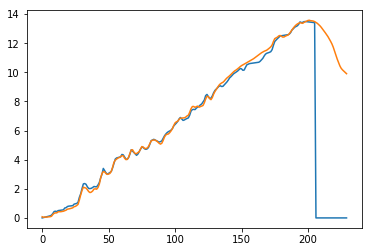

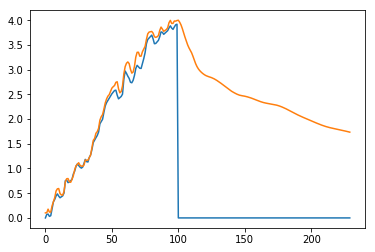

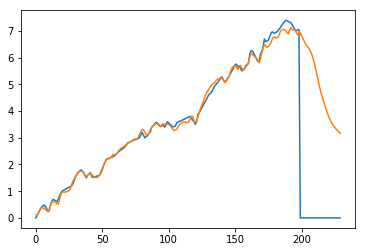

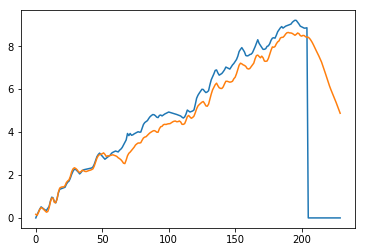

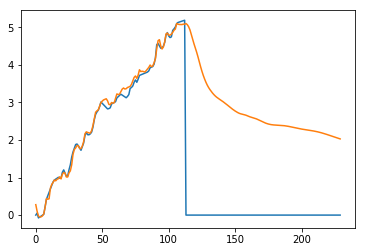

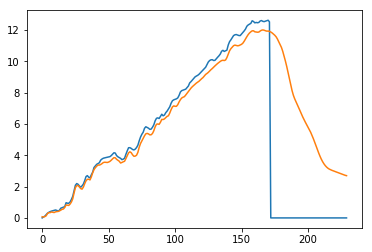

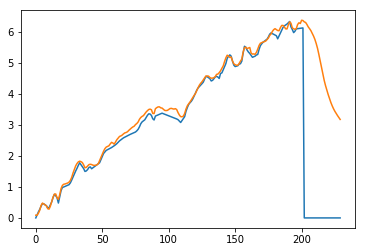

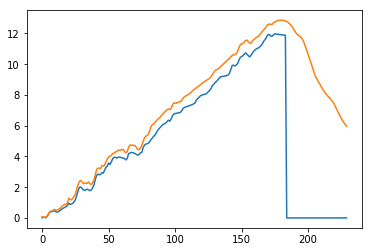

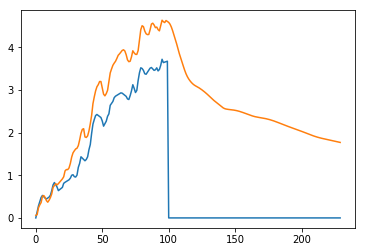

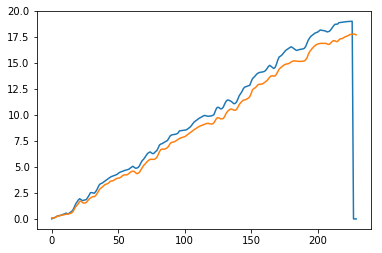

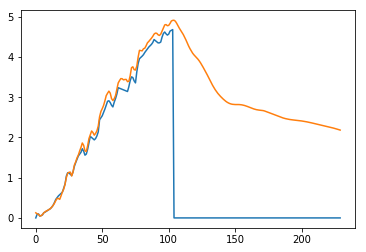

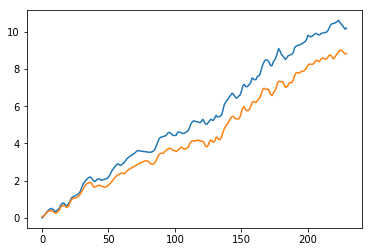

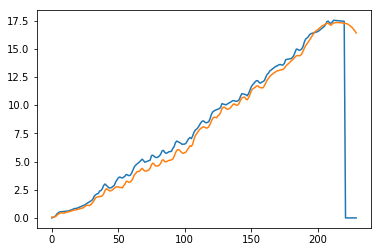

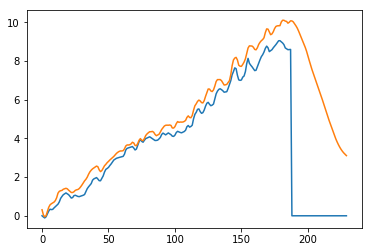

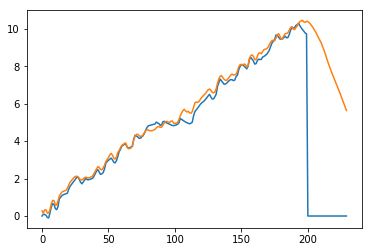

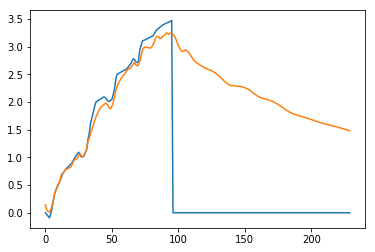

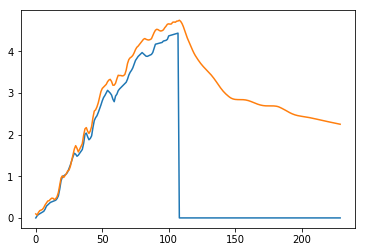

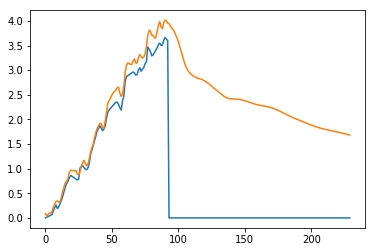

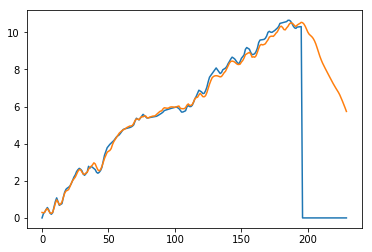

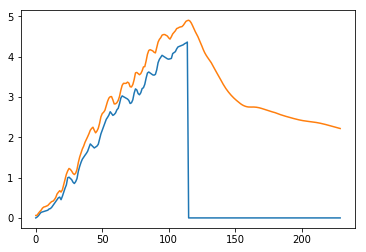

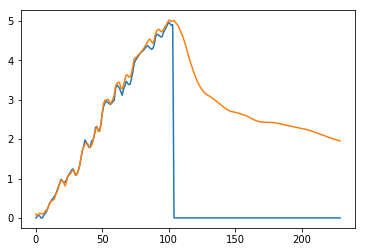

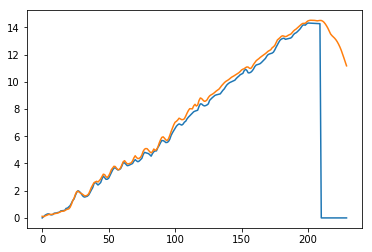

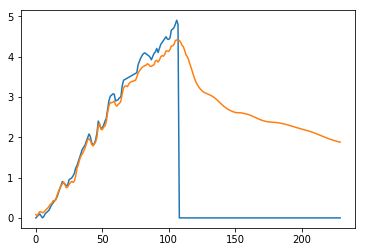

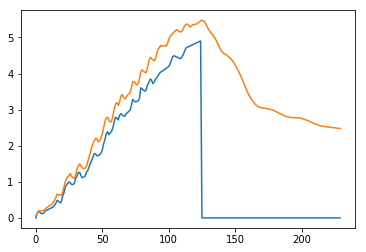

In [16]:
for gt, pred in zip (test_batch_y, preds):
    plt.figure()
    plt.plot(gt[gt != -999])
    plt.hold(True)
    plt.plot(pred)